# Evaluating Machine Learning models for Fashion Recognition
STUDENT: Brocco Mattia <br>
MATR. NUMBER: 2044714 <br>
*Machine and Deep Learning (Mod. A)* <br>
*Professor Da San Martino Giovanni* <br>
*LM Data Science* <br>
*A.Y. 2021/2022* <br>

In [1]:
import os
import ssl
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.request import urlopen

## <u>Data import</u>
The following cell (in Markdown) was executed the first time to fecth data from the online source the Professor provided, next all data was converted into a `Pandas.DataFrame` object and stored as a `.feather` file. This enable a very fast data retrieval even for large files. <br>
***WARNING***: the first Code cell will raise an error if the .feather file is not in the same directory of this notebook.

```python
ssl._create_default_https_context = ssl._create_unverified_context

def load_fashion_mnist():

    url_base = "https://www.math.unipd.it/~dasan/"
    Y_train = np.frombuffer(urlopen(url_base + "train-labels-idx1-ubyte").read(),
                            dtype = np.uint8, offset = 8)
    X_train = np.frombuffer(urlopen(url_base + "train-images-idx3-ubyte").read(),
                            dtype = np.uint8, offset = 16).reshape(len(Y_train), 784)
    # besides loadng the data, I already flatten it into a vector
    Y_test = np.frombuffer(urlopen(url_base + "t10k-labels-idx1-ubyte").read(),
                           dtype = np.uint8, offset = 8)
    X_test = np.frombuffer(urlopen(url_base + "t10k-images-idx3-ubyte").read(),
                           dtype = np.uint8, offset = 16).reshape(len(Y_test), 784)

    return X_train, Y_train, X_test, Y_test

X_train_val, y_train_val, X_test, y_test = load_fashion_mnist()
```

```python
# Create a DataFrame, one for training and one for testing (both with labels attached)
train_dataset = pd.DataFrame(np.c_[X_train, y_train], columns = [f"pxl_{x}" for x in range(784)] + ["Target"])
test_dataset = pd.DataFrame(np.c_[X_test, y_test], columns = [f"pxl_{x}" for x in range(784)] + ["Target"])

# Save files to feather in order to have faster access
train_dataset.to_feather("train_image_classification.feather")
test_dataset.to_feather("test_image_classification.feather")
```

In [2]:
if "train_image_classification.feather" not in os.listdir():
    raise FileNotFoundError

train = pd.read_feather("train_image_classification.feather")
test = pd.read_feather("test_image_classification.feather")

## <u>Exploratory Data Analysis</u>

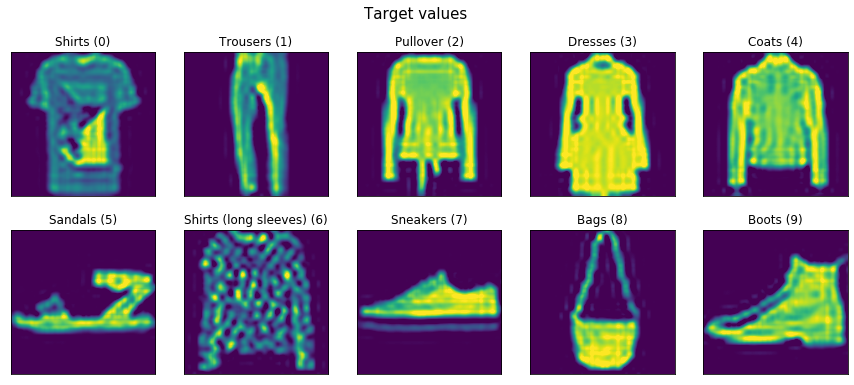

In [320]:
# First I need to know which clothes correspond to the target labels,
# i.e. WHAT IS THE TASK AT HAND?

label_dict = {0: "shirts", 1: "trousers", 2: "pullover",
              3: "dresses", 4: "coats", 5: "sandals",
              6: "shirts (long sleeves)", 7: "sneakers",
              8: "bags", 9: "boots"}

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 6))

for k in label_dict.keys():
    row = 0 if k < 5 else 1
    col = k if row == 0 else k - 5
    
    ax[row, col].imshow(train[train["Target"] == k].iloc[50,:-1].values.reshape(28, 28),
                        interpolation = "sinc")
    ax[row, col].xaxis.set_visible(False)
    ax[row, col].yaxis.set_visible(False)
    ax[row, col].set_title("{} ({})".format( label_dict[k].capitalize(), k ))
    
fig.suptitle("Target values", fontsize = 15)
plt.show() # bbox_inches = "tight", pad_inches = 0

In [4]:
# DATA QUALITY CHECK

print("Amount of NaN: {:.0f}".format( train.isnull().sum().sum() ))
print("Amount of rows with all same values: {:.0f}".format( train.eq(train.iloc[:, 0], axis = 0).all(1).sum() ))
print("Interval of data in train: [{}, {}]".format( train.drop("Target", axis = 1).min().min(),
                                                    train.drop("Target", axis = 1).max().max() ))
# It has also been checked that labels are in sparse order.

Amount of NaN: 0
Amount of rows with all same values: 0
Interval of data in train: [0, 255]


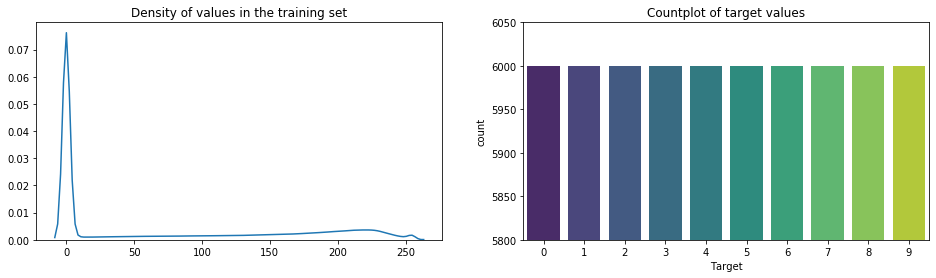

In [321]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 4))

# How are values in the training set distributed?
sns.kdeplot(train.drop("Target", axis = 1).values.flatten(), ax = ax[0])
ax[0].set_title("Density of values in the training set")

# Are the classes balanced? YES
sns.countplot(train["Target"], palette = "viridis", ax = ax[1])
ax[1].set_ylim(5800, 6050)
ax[1].set_title("Countplot of target values")

plt.show()

## <u>Data preprocessing</u>

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Scale data to have all in the range [0, 1]
# Every subset of features is applied with .fit_transform in order to
# ensure they all comprise only values in the range given by the scaler
scaler = MinMaxScaler()

X_train_val = train.drop("Target", axis = 1).values
y_train_val = train["Target"].values

X_train_val = scaler.fit_transform(X_train_val)

# Split train and validation (75% training)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                  train_size = .75, random_state = 101)

##### Test values
X_test = test.drop("Target", axis = 1).values
y_test = test["Target"].values

X_test = scaler.fit_transform(X_test)

## <u>Algorithms</u>

In [4]:
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve

## _Perceptron_
Fit both a Ove-vs-One and a One-vs-Rest to see which strategy performs better. <br>
Both model are trained on Train+Validation, since `Scikit Learn` allows (built-in) to keep a partion for validation (set to 25%). <br>
Hyperparameters tuning (3 fold CV on Train+Val) focuses on regularization, and it is applied only to the strategy (OvO / OvR) that shows the higher accuracy.

Train+Valid Accuracy OVO: 0.7964
Train+Valid Accuracy OVR: 0.8286

OVR strategy for Perceptron works better for the task

Fitting 3 folds for each of 4 candidates, totalling 12 fits
              precision    recall  f1-score   support

           0       0.79      0.74      0.76      6000
           1       0.96      0.93      0.95      6000
           2       0.62      0.74      0.67      6000
           3       0.85      0.76      0.80      6000
           4       0.67      0.79      0.72      6000
           5       0.84      0.72      0.78      6000
           6       0.58      0.47      0.52      6000
           7       0.68      0.97      0.80      6000
           8       0.94      0.87      0.90      6000
           9       0.96      0.77      0.85      6000

    accuracy                           0.78     60000
   macro avg       0.79      0.78      0.78     60000
weighted avg       0.79      0.78      0.78     60000



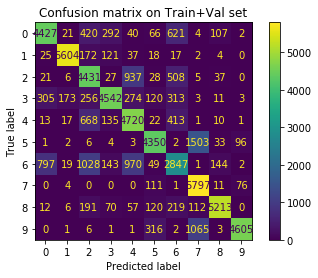

In [267]:
# Initialize a Perceptron
prc = Perceptron(n_jobs = -1, early_stopping = True, warm_start = False,
                 n_iter_no_change = 10, random_state = 101,
                 validation_fraction = 0.25)

# Encapsulate in a OvO classifier and compute Accuracy on Train+Val
prc_ovo = OneVsOneClassifier(prc)
prc_ovo.fit(X_train_val, y_train_val)
prc_ovo_acc = accuracy_score(y_train_val, prc_ovo.predict(X_train_val))
print("Train+Valid Accuracy OVO: {:.4f}".format(prc_ovo_acc))

# Encapsulate in a OvR classifier and compute Accuracy on Train+Val
prc_ovr = OneVsRestClassifier(prc)
prc_ovr.fit(X_train_val, y_train_val)
prc_ovr_acc = accuracy_score(y_train_val, prc_ovr.predict(X_train_val))
print("Train+Valid Accuracy OVR: {:.4f}\n".format(prc_ovr_acc))

# Tuning to implement different types of regua
prc_params = {"estimator__penalty": ["l1", "l2"], # default: None
              "estimator__alpha":[0.01, 0.001]} # default: 1e-4


if prc_ovo_acc > prc_ovr_acc:
    print("OVO strategy for Perceptron works better for the task\n")
    prc_grid = GridSearchCV(OneVsOneClassifier(Perceptron(n_jobs = -1, early_stopping = True,
                                                          warm_start = False, n_iter_no_change = 10,
                                                          random_state = 101, validation_fraction = 0.25)),
                            param_grid = prc_params, n_jobs = -1, cv = 3,
                            verbose = 10, return_train_score = True)
    
    prc_grid.fit(X_train_val, y_train_val)
    prc_grid_predicted = prc_grid.best_estimator_.predict(X_train_val)
    
    print(classification_report(y_train_val, prc_grid_predicted))
    ConfusionMatrixDisplay(confusion_matrix(y_train_val, prc_grid_predicted),
                       display_labels = prc_grid.best_estimator_.classes_).plot()
    plt.title("Confusion matrix on Train+Val set")
    plt.show()
else:
    print("OVR strategy for Perceptron works better for the task\n")
    prc_grid = GridSearchCV(OneVsRestClassifier(Perceptron(n_jobs = -1, early_stopping = True,
                                                           warm_start = False, n_iter_no_change = 10,
                                                           random_state = 101, validation_fraction = 0.25)),
                            param_grid = prc_params, n_jobs = -1, cv = 3,
                            verbose = 10, return_train_score = True)
    
    prc_grid.fit(X_train_val, y_train_val)
    prc_grid_predicted = prc_grid.best_estimator_.predict(X_train_val)
    
    print(classification_report(y_train_val, prc_grid_predicted))
    ConfusionMatrixDisplay(confusion_matrix(y_train_val, prc_grid_predicted),
                       display_labels = prc_grid.best_estimator_.classes_).plot()
    plt.title("Confusion matrix on Train+Val set")
    plt.show()

## _Logistic Regression_
First, a basic model is trained only on the training set.<br>
Then, hyperparamter tuning for the regularization term and type of penalty is performed on Train+Validation using a 3-fold cross validation strategy. <br>
***WARNING***: the following cell took almost 6 hours to execute on my machine

LogReg Train Accuracy: 0.8767

Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\matti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\matti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\matti\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


GridSearch Train+Val Acc.: 0.8719

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      6000
           1       0.98      0.97      0.98      6000
           2       0.78      0.78      0.78      6000
           3       0.86      0.90      0.88      6000
           4       0.77      0.81      0.79      6000
           5       0.96      0.95      0.95      6000
           6       0.70      0.60      0.65      6000
           7       0.93      0.94      0.94      6000
           8       0.95      0.96      0.95      6000
           9       0.96      0.96      0.96      6000

    accuracy                           0.87     60000
   macro avg       0.87      0.87      0.87     60000
weighted avg       0.87      0.87      0.87     60000



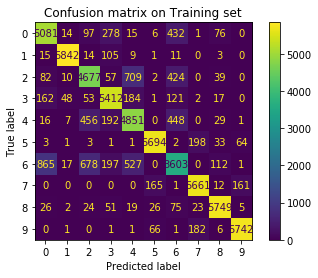

In [125]:
# Initialize a LogisticRegression (with OvR strategy for multiclass)
    # 'warm_start' should speed up training
    # 'max_iter' default is 100, here the amount of data required an increase
logreg = LogisticRegression(multi_class = "ovr", n_jobs = -1,
                            random_state = 101, max_iter = 1e3, 
                            solver = "saga", warm_start = True) 
logreg.fit(X_train, y_train)

print("LogReg Train Accuracy: {:.4f}\n".format((accuracy_score(y_train, logreg.predict(X_train)))))

# 3Fold CV for regularization
logreg_params = {"C":[1, 5], "penalty":["l1", "l2"]}
logreg_grid = GridSearchCV(logreg, logreg_params, n_jobs = 6,
                           cv = 3, verbose = 10, return_train_score = True)
logreg_grid.fit(X_train_val, y_train_val)

# Show the results
print("GridSearch Train+Val Acc.: {:.4f}\n".format((accuracy_score(y_train_val,
                                                            logreg_grid.best_estimator_.predict(X_train_val)))))
print(classification_report(y_train_val, logreg_grid.best_estimator_.predict(X_train_val)))
ConfusionMatrixDisplay(confusion_matrix(y_train_val, logreg_grid.best_estimator_.predict(X_train_val)),
                       display_labels = logreg_grid.best_estimator_.classes_).plot()
plt.title("Confusion matrix on Train+Val set")
plt.show()

## _Kernel Methods (SVM)_
First, a basic model is trained only on the training set.<br>
Then, hyperparamter tuning for the regularization term and type of penalty is performed on Train+Validation using a 3-fold cross validation strategy.
***WARNING***: the following cell took almost 2 hours to execute on my machine

SVC Train Accuracy: 0.9107

GridSearch Train+Val Accuracy: 0.9718

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      6000
           1       1.00      1.00      1.00      6000
           2       0.95      0.95      0.95      6000
           3       0.97      0.98      0.97      6000
           4       0.94      0.95      0.94      6000
           5       1.00      1.00      1.00      6000
           6       0.95      0.90      0.92      6000
           7       0.98      0.99      0.99      6000
           8       1.00      1.00      1.00      6000
           9       0.99      0.99      0.99      6000

    accuracy                           0.97     60000
   macro avg       0.97      0.97      0.97     60000
weighted avg       0.97      0.97      0.97     60000



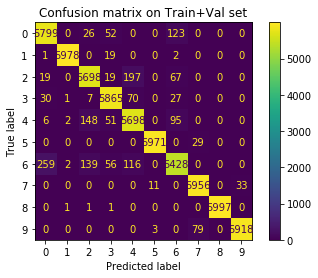

In [148]:
# Initialize a Support Vector Classifier (with OvR strategy for multiclass)
svc = SVC(random_state = 101, decision_function_shape = "ovr")
svc.fit(X_train, y_train)
print("SVC Train Accuracy: {:.4f}\n".format((accuracy_score(y_train, svc.predict(X_train)))))

svc_hyperparam = {"C":[1, 5, 10]}
svc_grid = GridSearchCV(SVC(random_state = 101, decision_function_shape = "ovr"), svc_hyperparam,
                        n_jobs = -1, cv = 3, verbose = 10,
                        return_train_score = True)

svc_grid.fit(X_train_val, y_train_val)

svc_predicted = svc_grid.best_estimator_.predict(X_train_val)
# Show the results
print("GridSearch Train+Val Accuracy: {:.4f}\n".format((accuracy_score(y_train_val, svc_predicted))))
print(classification_report(y_train_val, svc_predicted))
ConfusionMatrixDisplay(confusion_matrix(y_train_val, svc_predicted),
                       display_labels = svc_grid.best_estimator_.classes_).plot()
plt.title("Confusion matrix on Train+Val set")
plt.show()

***WARNING***: the following cell took almost 2 hours to execute on my machine

In [197]:
# Compute and plot the learning curve
# for SVC to make sure it isn't overfitting
    # from the plot is likely to be slightly present
    # 'C' from GridSearch: 10
svc_learning_curve = learning_curve(svc_grid.best_estimator_, X_train_val, y_train_val,
                                    train_sizes = np.linspace(0.1, 1.0, 5), cv = 3,
                                    scoring = "accuracy", random_state = 101,
                                    return_times = True)

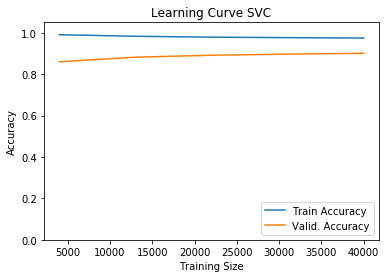

In [201]:
plt.title("Learning Curve SVC")
plt.plot(svc_learning_curve[0], svc_learning_curve[1].mean(axis = 1), label = "Train Accuracy")
plt.plot(svc_learning_curve[0], svc_learning_curve[2].mean(axis = 1), label = "Valid. Accuracy")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")
plt.ylim(0, 1.05)
plt.show()

## _Tree Classifier_
First, train a tree with no other parameters than default's. The tree is likely to overfit, thus some ex-post **pruning** is performed. In order to assess how much impurity should be kept, A 3fold CV is done on the hyperparameter `ccp_alpha`.

Tree Train Accuracy: 1.0000



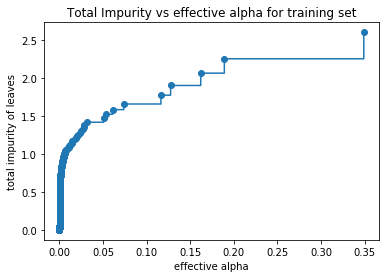

Fitting 3 folds for each of 5 candidates, totalling 15 fits
GridSearch Train+Val Accuracy: 0.8562

              precision    recall  f1-score   support

           0       0.78      0.87      0.82      6000
           1       0.98      0.96      0.97      6000
           2       0.74      0.80      0.77      6000
           3       0.86      0.87      0.87      6000
           4       0.76      0.76      0.76      6000
           5       0.94      0.92      0.93      6000
           6       0.72      0.57      0.64      6000
           7       0.91      0.92      0.91      6000
           8       0.95      0.96      0.95      6000
           9       0.93      0.94      0.93      6000

    accuracy                           0.86     60000
   macro avg       0.86      0.86      0.85     60000
weighted avg       0.86      0.86      0.85     60000



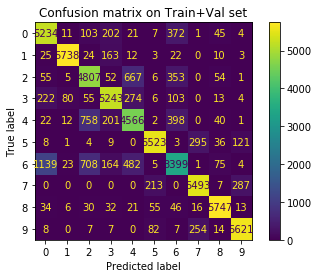

In [6]:
# Initialize a Decision Tree Classifier
tree = DecisionTreeClassifier(random_state = 101, criterion = "entropy")
tree.fit(X_train, y_train)
print("Tree Train Accuracy: {:.4f}\n".format((accuracy_score(y_train, tree.predict(X_train)))))

# Compute impurities to look for an adequate pruning term
path = tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
# Plot the impurity level given ccp_alpha
plt.plot(ccp_alphas[:-1], impurities[:-1], marker = "o", drawstyle = "steps-post")
plt.xlabel("effective alpha")
plt.ylabel("total impurity of leaves")
plt.title("Total Impurity vs effective alpha for training set")
plt.show()

# Tree Pruning (we are overfitting - Accuracy: 100% in training)
tree_params = {"ccp_alpha":[ccp_alphas[impurities < impty].max()
                            for impty in np.linspace(0.1, np.round(impurities.max()/2, 3),
                                                     num = 5)]}

tree_grid = GridSearchCV(DecisionTreeClassifier(random_state = 101, criterion = "entropy"),
                         tree_params, cv = 3, n_jobs = 6, verbose = 10,
                         return_train_score = True)
tree_grid.fit(X_train_val, y_train_val)

# Show the results
print("GridSearch Train+Val Accuracy: {:.4f}\n".format((accuracy_score(y_train_val,
                                                                       tree_grid.best_estimator_.predict(X_train_val)))))
print(classification_report(y_train_val, tree_grid.best_estimator_.predict(X_train_val)))
ConfusionMatrixDisplay(confusion_matrix(y_train_val, tree_grid.best_estimator_.predict(X_train_val)),
                       display_labels = tree_grid.best_estimator_.classes_).plot()
plt.title("Confusion matrix on Train+Val set")
plt.show()

## _Ensemble learning (Random Forest)_
To start, the random forest will be made with some of the parameters of the Decision Tree found above. In particular, `max_depth = 15`

Tree Train Accuracy: 0.9972

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Train+Val GridSearch Acc.: 0.9585

              precision    recall  f1-score   support

           0       0.92      0.95      0.93      6000
           1       1.00      1.00      1.00      6000
           2       0.91      0.92      0.91      6000
           3       0.96      0.97      0.97      6000
           4       0.90      0.92      0.91      6000
           5       1.00      1.00      1.00      6000
           6       0.90      0.82      0.86      6000
           7       1.00      1.00      1.00      6000
           8       1.00      1.00      1.00      6000
           9       1.00      1.00      1.00      6000

    accuracy                           0.96     60000
   macro avg       0.96      0.96      0.96     60000
weighted avg       0.96      0.96      0.96     60000



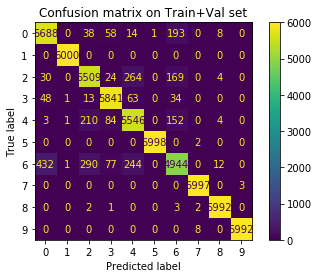

In [7]:
# LightGBM for Random Forest (it should be faster)
    # 'boosting_type' is Gradient Boosting Decision Tree by default
    # 'n_jobs' set to -1 is used in the whole Notebook when possible
    # to use all available processors and save time
rf = lgb.LGBMClassifier(boosting_type = "gbdt", n_estimators = 100,
                        objective = "multiclass",
                        max_depth = tree_grid.best_estimator_.get_depth(), # 15
                        n_jobs = -1, random_state = 101)
rf.fit(X_train, y_train)
print("Tree Train Accuracy: {:.4f}\n".format((accuracy_score(y_train, rf.predict(X_train)))))

rf_params = {"n_estimators":[10, 20, 50]}

rf_grid = GridSearchCV(lgb.LGBMClassifier(boosting_type = "gbdt",
                                          objective = "multiclass",
                                          max_depth = tree_grid.best_estimator_.get_depth(), # 15
                                          n_jobs = -1, random_state = 101),
                       rf_params, cv = 3, n_jobs = -1, verbose = 10, return_train_score = True)
rf_grid.fit(X_train_val, y_train_val)
# Show the results
print("Train+Val GridSearch Acc.: {:.4f}\n".format(accuracy_score(y_train_val,
                                                                  rf_grid.best_estimator_.predict(X_train_val)) ))
print(classification_report(y_train_val, rf_grid.best_estimator_.predict(X_train_val)))
ConfusionMatrixDisplay(confusion_matrix(y_train_val, rf_grid.best_estimator_.predict(X_train_val)),
                       display_labels = rf_grid.best_estimator_.classes_).plot()
plt.title("Confusion matrix on Train+Val set")
plt.show()

In [8]:
rf_grid.best_params_

{'n_estimators': 50}

In [280]:
# Compute and plot the learning curve for
# Random Forest to make sure it isn't overfitting
    # from the plot is likely to be slightly present
rf_learning_curve = learning_curve(rf_grid.best_estimator_, X_train_val, y_train_val,
                                   train_sizes = np.linspace(0.1, 1.0, 5), cv = 3,
                                   scoring = "accuracy", random_state = 101,
                                   return_times = True)

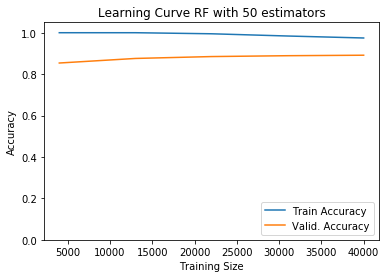

In [313]:
plt.title("Learning Curve RF with 50 estimators")
plt.plot(rf_learning_curve[0], rf_learning_curve[1].mean(axis = 1), label = "Train Accuracy")
plt.plot(rf_learning_curve[0], rf_learning_curve[2].mean(axis = 1), label = "Valid. Accuracy")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")
plt.ylim(0, 1.05)
plt.show()

## _Neural Network_
To find the most suitable architecture, while keeping the running time acceptable on the machine I am using, I've followed this procedure:<br>
1. Choose the number of layers
2. Choose the number of units per layer
3. Choose the activation function

In [13]:
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.python.framework.random_seed import set_random_seed

## Data preprocessing for Neural Network
y_train_val_cat = to_categorical(y_train_val, 10)
y_test_cat = to_categorical(y_test, 10)

## Define an Early Stopping
early_stopping = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5, verbose = 0)

In [287]:
# (1) CHOOSE THE NUMBER OF LAYERS

def NN_with_layers(n_layers, input_size, n_classes):
    np.random.seed(101)
    set_random_seed(101)
    
    nn = Sequential()
    for i in range(1, n_layers):
        if i == 1:
             nn.add(Dense(input_dim = input_size, units = int(np.sqrt(input_size)), activation = "relu"))
        else:
            nn.add(Dense(units = int(np.sqrt(input_size)), activation = "relu"))
    # output layer
    nn.add(Dense(units = n_classes, activation = "softmax"))
    
    nn.compile(loss = "categorical_crossentropy", optimizer = "sgd", metrics = ["accuracy"])
    return nn

# Try several number of layers
nlayers = range(2, 22)
layers_histories = []
for nl in nlayers:
    # Run the function & fit the model
    for_m = NN_with_layers(n_layers = nl, input_size = 784, n_classes = 10)

    for_h = for_m.fit(X_train_val, y_train_val_cat, epochs = 500,
                      batch_size = 100, verbose = 0, validation_split = 0.3,
                      callbacks = [early_stopping])
    # Show progress
    print("N layers:{}\t\tTrain ACC:{:.4f}\tVal ACC:{:.4f}".format( nl, for_h.history['accuracy'][-1],
                                                                    for_h.history['val_accuracy'][-1] ))
    layers_histories += [for_h]

N layers:2		Train ACC:0.8870	Val ACC:0.8701
N layers:3		Train ACC:0.8757	Val ACC:0.8617
N layers:4		Train ACC:0.8917	Val ACC:0.8713
N layers:5		Train ACC:0.8963	Val ACC:0.8739
N layers:6		Train ACC:0.8835	Val ACC:0.8667
N layers:7		Train ACC:0.8850	Val ACC:0.8540
N layers:8		Train ACC:0.8832	Val ACC:0.8590
N layers:9		Train ACC:0.8648	Val ACC:0.8498
N layers:10		Train ACC:0.8650	Val ACC:0.8502
N layers:11		Train ACC:0.8772	Val ACC:0.8595
N layers:12		Train ACC:0.8870	Val ACC:0.8678
N layers:13		Train ACC:0.8883	Val ACC:0.8626
N layers:14		Train ACC:0.8613	Val ACC:0.8512
N layers:15		Train ACC:0.8808	Val ACC:0.8558
N layers:16		Train ACC:0.8852	Val ACC:0.8664
N layers:17		Train ACC:0.8740	Val ACC:0.8458
N layers:18		Train ACC:0.8756	Val ACC:0.8514
N layers:19		Train ACC:0.8731	Val ACC:0.8521
N layers:20		Train ACC:0.8884	Val ACC:0.8664
N layers:21		Train ACC:0.8524	Val ACC:0.8425


    # Layers: 5
Val Accuracy: 0.8739


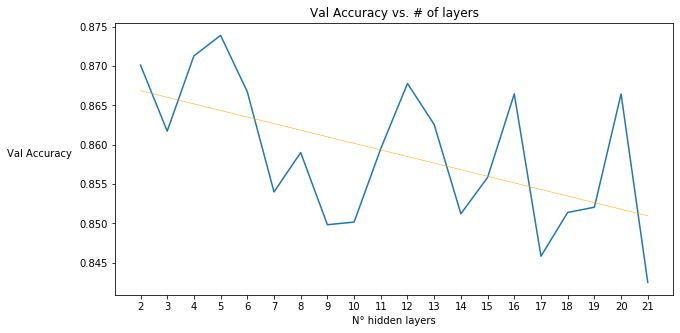

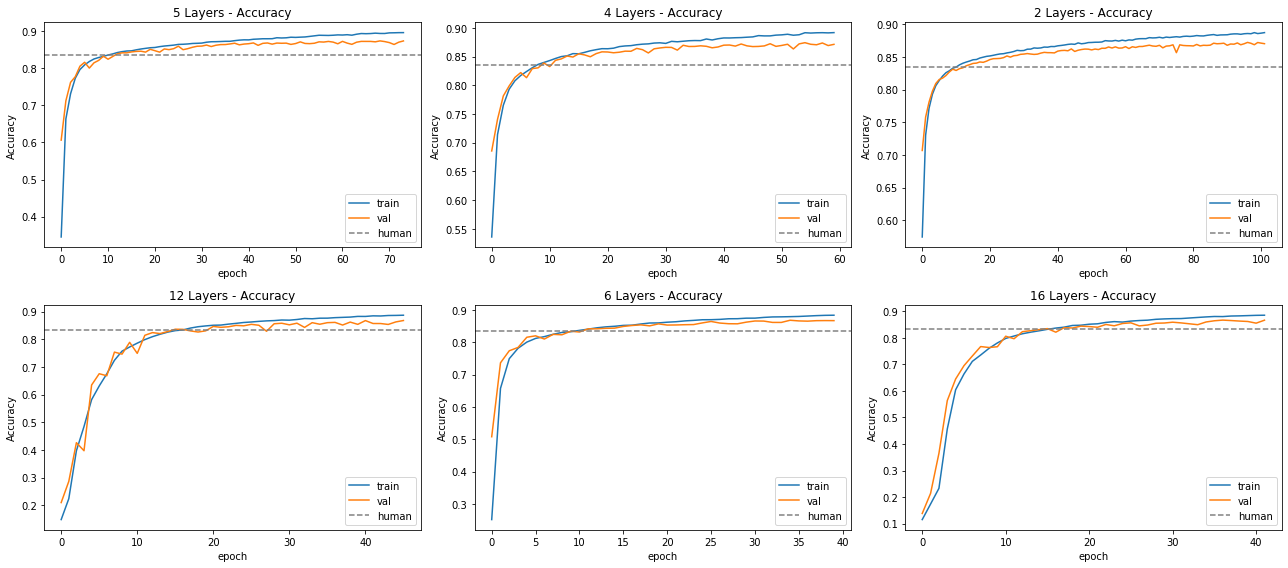

In [288]:
# List of tuples with validation accuracies and the corresponding n° of layers
layr_val_accs = [(n+2, layers_histories[n].history["val_accuracy"][-1]) for n in range(len(layers_histories))]
# Sort the previous list and get the first six results
layer_most_acc = sorted(layr_val_accs, key = lambda v: v[1], reverse = True)[:6]

# Print the best result
print(f"    # Layers: {list(nlayers)[sorted(layr_val_accs, key = lambda v: v[1], reverse = True)[0][0]-2]}")
print(f"Val Accuracy: {sorted(layr_val_accs, key = lambda v: v[1], reverse = True)[0][1]:.4f}")

# Get only the n° layers values
layer_most_acc = [x[0] - 2 for x in layer_most_acc]

# The following plot is meant to show the trend
# of validation accuracy against the number of layers
plt.figure(figsize = (10, 5))
plt.plot([x[0] for x in layr_val_accs], [x[1] for x in layr_val_accs])
plt.xlabel("N° hidden layers")
plt.ylabel("Val Accuracy", rotation = 0, labelpad = 40)
plt.title("Val Accuracy vs. # of layers")
m, b = np.polyfit([x[0] for x in layr_val_accs], [x[1] for x in layr_val_accs], 1)
plt.plot([x[0] for x in layr_val_accs], m*np.array([x[0] for x in layr_val_accs]) + b,
         color = "orange", lw = .5)
plt.xticks(nlayers)
plt.show()

# Plot the learning curves for the top-6 results
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18, 8))
for n, i in enumerate(layer_most_acc):
    row, col = int(n/3), n%3
    
    ax[row, col].plot(layers_histories[i].history["accuracy"], label = "train")
    ax[row, col].plot(layers_histories[i].history["val_accuracy"], label = "val")
    ax[row, col].set_title("{} Layers - Accuracy".format(i+2))
    ax[row, col].set_xlabel("epoch")
    ax[row, col].set_ylabel("Accuracy")
    ax[row, col].axhline(.835, color = "grey", ls = "--", label = "human") # human performance
    ax[row, col].legend(loc = "lower right")    
    
plt.tight_layout()
plt.show()

In [300]:
# (2) CHOOSE THE NUMBER OF UNITS PER LAYER (5 LAYERS)

def NN_with_units(lev_units, input_size, n_classes):
    np.random.seed(101)
    set_random_seed(101)
    
    nn = Sequential()
    
    for n in range(len(lev_units)):
        if n == 0:
            nn.add(Dense(input_dim = input_size, units = lev_units[n], activation = "relu" ))
        else:
            nn.add(Dense(units = lev_units[n], activation = "relu"))
    # output layer
    nn.add(Dense(units = n_classes, activation = "softmax"))
    
    nn.compile(loss = "categorical_crossentropy", optimizer = "sgd", metrics = ["accuracy"])
    return nn

nunits_try = [ [28, 28, 28, 28], [50, 50, 50, 50], [100, 100, 100, 100],
               [200, 200, 200, 200], [300, 300, 300, 300], [400, 400, 400, 400] ]

nuts_histories = []
for comb in nunits_try:
    # Run the function & fit the model
    for_m = NN_with_units(lev_units = comb, input_size = 784, n_classes = 10)
    for_h = for_m.fit(X_train_val, y_train_val_cat, epochs = 500, batch_size = 100,
                      verbose = 0, validation_split = 0.3,
                      callbacks = [early_stopping])
    # Show progress
    if comb[0] < 100:
        print("Comb:{}\t\t\tTrain ACC:{:.4f}\tVal ACC:{:.4f}".format( comb, for_h.history['accuracy'][-1],
                                                                      for_h.history['val_accuracy'][-1] ))
    else:    
        print("Comb:{}\t\tTrain ACC:{:.4f}\tVal ACC:{:.4f}".format( comb, for_h.history['accuracy'][-1],
                                                                    for_h.history['val_accuracy'][-1] ))
    nuts_histories += [for_h]

Comb:[28, 28, 28, 28]			Train ACC:0.8963	Val ACC:0.8739
Comb:[50, 50, 50, 50]			Train ACC:0.8920	Val ACC:0.8714
Comb:[100, 100, 100, 100]		Train ACC:0.9015	Val ACC:0.8796
Comb:[200, 200, 200, 200]		Train ACC:0.9151	Val ACC:0.8856
Comb:[300, 300, 300, 300]		Train ACC:0.9145	Val ACC:0.8834
Comb:[400, 400, 400, 400]		Train ACC:0.9168	Val ACC:0.8814


     # Units: [200, 200, 200, 200]
Val Accuracy: 0.8856


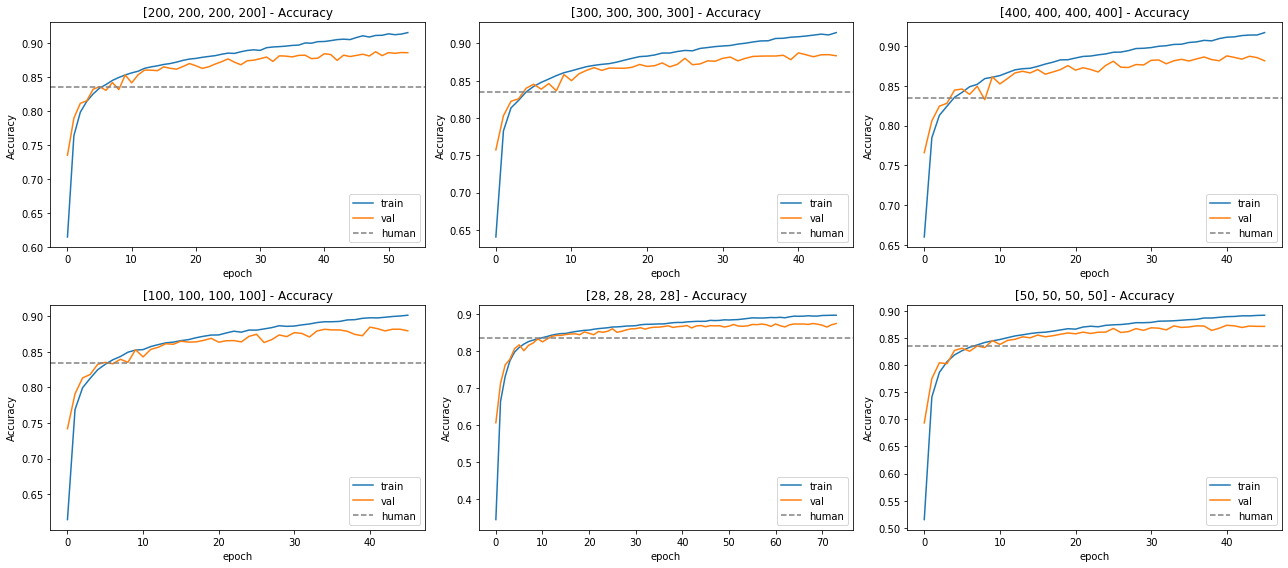

In [361]:
# List of tuples with validation accuracies and the units per layer
nuts_val_accs = [(n, nuts_histories[n].history["val_accuracy"][-1]) for n in range(len(nuts_histories))]
# Sort the previous list and get the first six results
nuts_most_acc = sorted(nuts_val_accs, key = lambda v: v[1], reverse = True)[:6]

# Print the best result
print(f"     # Units: {nunits_try[sorted(nuts_val_accs, key = lambda v: v[1], reverse = True)[0][0]]}")
print(f"Val Accuracy: {sorted(nuts_most_acc, key = lambda v: v[1], reverse = True)[0][1]:.4f}")

# Get only the combos values
nuts_most_acc = [x[0] for x in nuts_most_acc]

# Plot the learning curves for the top-6 results
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18, 8))
for n, i in enumerate(nuts_most_acc):
    row, col = int(n/3), n%3

    ax[row, col].plot(nuts_histories[i].history["accuracy"], label = "train")
    ax[row, col].plot(nuts_histories[i].history["val_accuracy"], label = "val")
    ax[row, col].set_title("{} - Accuracy".format( nunits_try[i] ))
    ax[row, col].set_xlabel("epoch")
    ax[row, col].set_ylabel("Accuracy")
    ax[row, col].axhline(.835, color = "grey", ls = "--", label = "human") # human performance
    ax[row, col].legend(loc = "lower right")

plt.tight_layout()
plt.show()

In [302]:
# (3) CHOOSE THE ACTIVATION FUNCTION (5 LAYERS)

def NN_with_activf(activ_functions, input_size, n_classes):
    np.random.seed(101)
    set_random_seed(101)
    
    nn = Sequential()
    for n in range(len(activ_functions)):
        if n == 0:
            nn.add(Dense(input_dim = input_size, units = 50, activation = activ_functions[n] ))
        else:
            nn.add(Dense(units = 50, activation = activ_functions[n]))
    # output layer
    nn.add(Dense(units = n_classes, activation = "softmax"))
    
    nn.compile(loss = "categorical_crossentropy", optimizer = "sgd", metrics = ["accuracy"])
    return nn


af_combs = [ ["relu", "relu", "relu", "relu"], ["relu", "relu", "relu", "elu"],
             ["relu", "relu", "elu", "relu"], ["relu", "elu", "relu", "relu"],
             ["relu", "relu", "elu", "elu"], ["relu", "elu", "relu", "elu"], 
             ["relu", "elu", "elu", "elu"] ]

afs_histories = []
for comb in af_combs:
    # Run the function & fit the model
    for_m = NN_with_activf(activ_functions = comb, input_size = 784, n_classes = 10)
    for_h = for_m.fit(X_train_val, y_train_val_cat, epochs = 500, batch_size = 100,
                      verbose = 0, validation_split = 0.3, callbacks = [early_stopping])
    # Show progress
    print("Combo:{}\t\tTrain ACC:{:.4f}\tVal ACC:{:.4f}".format( comb, for_h.history['accuracy'][-1],
                                                                 for_h.history['val_accuracy'][-1] ))
    afs_histories += [for_h]

Combo:['relu', 'relu', 'relu', 'relu']		Train ACC:0.8920	Val ACC:0.8714
Combo:['relu', 'relu', 'relu', 'elu']		Train ACC:0.8926	Val ACC:0.8719
Combo:['relu', 'relu', 'elu', 'relu']		Train ACC:0.8939	Val ACC:0.8734
Combo:['relu', 'elu', 'relu', 'relu']		Train ACC:0.8889	Val ACC:0.8724
Combo:['relu', 'relu', 'elu', 'elu']		Train ACC:0.9034	Val ACC:0.8768
Combo:['relu', 'elu', 'relu', 'elu']		Train ACC:0.8885	Val ACC:0.8694
Combo:['relu', 'elu', 'elu', 'elu']		Train ACC:0.8941	Val ACC:0.8745


 Activ. Func: ['relu', 'relu', 'elu', 'elu']
Val Accuracy: 0.8768


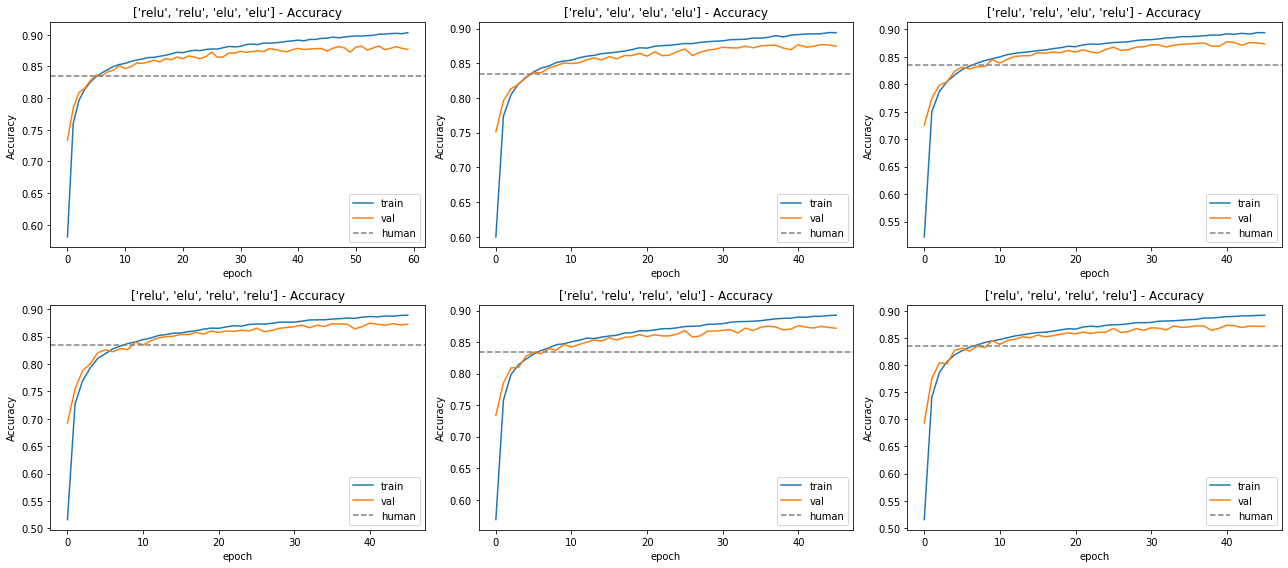

In [303]:
afs_val_acc = [(n, afs_histories[n].history["val_accuracy"][-1]) for n in range(len(afs_histories))]
# Sort the previous list and get the first six results
afs_val_acc = sorted(afs_val_acc, key = lambda v: v[1], reverse = True)[:6]

print(f" Activ. Func: {af_combs[sorted(afs_val_acc, key = lambda v: v[1], reverse = True)[0][0]]}")
print(f"Val Accuracy: {sorted(afs_val_acc, key = lambda v: v[1], reverse = True)[0][1]:.4f}")

# Get only the combos values
afs_val_acc = [x[0] for x in afs_val_acc]

# Plot the learning curves for the top-6 results
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18, 8))
for n, i in enumerate(afs_val_acc):
    row = int(n/3)
    col = n%3
    
    ax[row, col].plot(afs_histories[i].history["accuracy"], label = "train")
    ax[row, col].plot(afs_histories[i].history["val_accuracy"], label = "val")
    ax[row, col].set_title("{} - Accuracy".format( af_combs[i] ))
    ax[row, col].set_xlabel("epoch")
    ax[row, col].set_ylabel("Accuracy")
    ax[row, col].axhline(.835, color = "grey", ls = "--", label = "human") # human performance
    ax[row, col].legend(loc = "lower right")

plt.tight_layout()
plt.show()

Here, the final architecture is displayed.

In [305]:
model = Sequential()
model.add(Dense(input_dim = 784, units = 50, activation = "relu"))
model.add(Dense(units = 50, activation = "elu"))
model.add(Dense(units = 50, activation = "relu"))
model.add(Dense(units = 50, activation = "relu"))
model.add(Dense(units = 10, activation = "softmax"))
model.compile(loss = "categorical_crossentropy", optimizer = "sgd", metrics = ["accuracy"])

print(model.summary())
#plot_model(model, show_shapes = True)

history = model.fit(X_train_val, y_train_val_cat, epochs = 500, batch_size = 100,
                    verbose = 0, validation_split = 0.3, callbacks = [early_stopping])

Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_670 (Dense)           (None, 50)                39250     
                                                                 
 dense_671 (Dense)           (None, 50)                2550      
                                                                 
 dense_672 (Dense)           (None, 50)                2550      
                                                                 
 dense_673 (Dense)           (None, 50)                2550      
                                                                 
 dense_674 (Dense)           (None, 10)                510       
                                                                 
Total params: 47,410
Trainable params: 47,410
Non-trainable params: 0
_________________________________________________________________
None


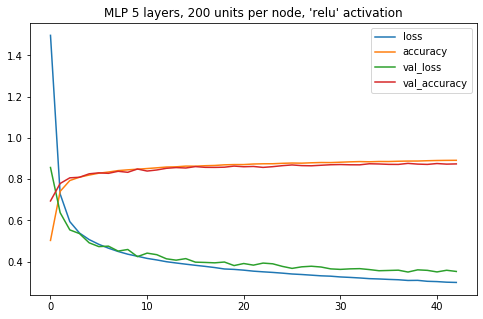

In [306]:
# Plot the result
pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.title("MLP 5 layers, 200 units per node, 'relu' activation")
plt.show()

              precision    recall  f1-score   support

           0       0.85      0.84      0.84      6000
           1       0.99      0.97      0.98      6000
           2       0.80      0.83      0.81      6000
           3       0.89      0.90      0.90      6000
           4       0.84      0.78      0.81      6000
           5       0.94      0.98      0.96      6000
           6       0.71      0.73      0.72      6000
           7       0.96      0.92      0.94      6000
           8       0.95      0.97      0.96      6000
           9       0.96      0.97      0.96      6000

    accuracy                           0.89     60000
   macro avg       0.89      0.89      0.89     60000
weighted avg       0.89      0.89      0.89     60000



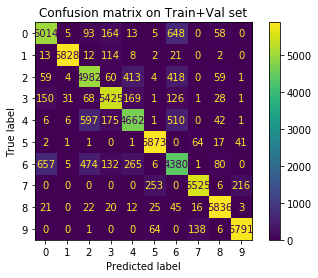

In [307]:
print(classification_report(y_train_val, pd.DataFrame(model.predict(X_train_val)).idxmax(axis = 1).values))
ConfusionMatrixDisplay(confusion_matrix(y_train_val, pd.DataFrame(model.predict(X_train_val)).idxmax(axis = 1).values),
                       display_labels = rf_grid.best_estimator_.classes_).plot()
plt.title("Confusion matrix on Train+Val set")
plt.show()

## <u>Evaluation on the test set for the TOP 3 models</u>
For the Multilayer Perceptron and the Random Forest, the predict time is sample 100 times, for the Support Vector Machine only one and that is enough to see the striking difference.

In [308]:
# Neural Network
ann_pred_times = []
for n in range(100):
    ann_start = time.time()
    model.predict(X_test)
    ann_end = time.time()
    ann_pred_times += [ann_end-ann_start]

print("Predictions/sec: {:.0f}\n".format( X_test.shape[0]/np.array(ann_pred_times).mean() ))
print(classification_report(y_test, pd.DataFrame(model.predict(X_test)).idxmax(axis = 1).values))

Predictions/sec: 22195

              precision    recall  f1-score   support

           0       0.83      0.80      0.82      1000
           1       0.99      0.96      0.97      1000
           2       0.75      0.80      0.78      1000
           3       0.85      0.88      0.87      1000
           4       0.81      0.74      0.77      1000
           5       0.92      0.96      0.94      1000
           6       0.67      0.68      0.67      1000
           7       0.94      0.91      0.93      1000
           8       0.93      0.96      0.94      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



In [252]:
# Support Vector Classifier
svc_start = time.time()
svc_test_pred = svc_grid.best_estimator_.predict(X_test)
svc_end = time.time()
print("Predictions/sec: {:.0f}\n".format( X_test.shape[0]/(svc_end-svc_start) ))
print(classification_report(y_test, svc_test_pred))

Predictions/sec: 65

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.81      0.84      0.82      1000
           3       0.90      0.91      0.91      1000
           4       0.83      0.84      0.83      1000
           5       0.97      0.97      0.97      1000
           6       0.75      0.72      0.73      1000
           7       0.95      0.96      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [277]:
# Random Forest
rf_pred_times = []
for n in range(100):
    rf_start = time.time()
    rf_grid.best_estimator_.predict(X_test)
    rf_end = time.time()
    rf_pred_times += [rf_end-rf_start]

print("Predictions/sec: {:.0f}\n".format( X_test.shape[0]/np.array(rf_pred_times).mean() ))
print(classification_report(y_test, rf_grid.best_estimator_.predict(X_test)))

Predictions/sec: 69359

              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.78      0.82      0.80      1000
           3       0.88      0.90      0.89      1000
           4       0.79      0.81      0.80      1000
           5       0.98      0.96      0.97      1000
           6       0.70      0.64      0.67      1000
           7       0.94      0.97      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.88      0.89      0.88     10000
weighted avg       0.88      0.89      0.88     10000



```python
# Submit prediction
prediction = rf_grid.best_estimator_.predict(X_test)
prediction.to_excel("sumbission.xlsx", index = False)
```

In [9]:
svc = SVC(random_state = 101, decision_function_shape = "ovr", C = 10)
svc.fit(X_train, y_train)
svc_preds = svc.predict(X_test)

---
---
---